In [1]:
from pathlib import Path
from thermophysicalProperties import Database
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
import pint
ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
from uncertainties import ufloat
import os, sys
from numdifftools import Derivative
from scipy.optimize import minimize
import warnings
from paths import THERMOCHIMICA, THERMOCHIMICA_FLUORIDE_DATA, MSTDB_TP_DATA, MSTDB_TP_RK_DATA, SALT_OPTIMIZATION

warnings.filterwarnings("ignore")

import thermoToolsAdditions as tta
from thermoToolsAdditions import convert_to_thermochem_name

# File IO input parameters for thermoToolsAdditions
tta.Config.set_config(
    thermochimica_path = THERMOCHIMICA,
    output_path = SALT_OPTIMIZATION / 'thermophysicalProperties',
    data_file = THERMOCHIMICA_FLUORIDE_DATA
)

db = Database(MSTDB_TP_DATA, MSTDB_TP_RK_DATA)

# Coolant Salt Optimization
In the literature, there seems to be a consensus that a fluoride-based coolant salt is superior from the standpoint of thermophsyical properties, so it was chosen for this project. The following endmembers are under consideration (and their composition will be optimized in the following section)
1. $\text{NaF}$
2. $\text{KF}$
3. $\text{ZrF}_4$
4. $\text{CaF}_2$

Notably, $\text{LiF}$ and $\text{BeF}_2$ were excluded because of the prototypical issues caused by tritium breeding in lithium, and the relatively high chemical toxicity of beryllium. The following criteria where considered for optimization
1. High heat capacity
2. Large volumetric expansion coefficient 
   1. I.e. $\beta = - \frac{1}{\rho}\big( \frac{\partial \rho}{\partial T}\big)_p$
3. Low viscosity

This is inherently a multiobjective problem, so we must have a method for evaluating each salt based on its thermophysical properties. To simplify the analysis, consider the following expression for the heat transfer rate
\begin{equation}
   \dot{q}_{cool} = 2\pi r L \overline{h} (\overline{T}_s - \overline{T}_\infty) = 2\pi r L \overline{h}\Delta T\nonumber
\end{equation}
where $L$ is the core height, and $2\pi rL$ represents the heated surface area of a single fuel rod of outer radius $r$. $\overline{h}$ is the heat transfer coefficient, and $\overline{T}_s$ and $\overline{T}_\infty$ are the average surface temperature of the fuel rod and the average ambient coolant temperature respectively. The heat transfer rate increases if the surface temperature increases, however this is constrained by material integrity, in addition, increasing the core height or the fuel rod radius will also increase the heat transfer rate, but doing so will lead to higher temperatures within the fuel rod, and these changes are also constrained. The only variable that can be nontrivially changed is the heat transfer coefficient, which depends on the thermophysical properties of the coolant. It is for this reason that we fix $r=4$ mm, $L=5$ m, and consider a (limiting) $\Delta T = 200$ K (and $T_\infty = 1000$ K), however it is the hope that these values should not affect the optimum salt composition, otherwise our minimum is conditional on the assumed operating parameters.
  
So, for a simplfied analysis, it is sufficient to optimize the heat transfer coefficient $h$, which is given in terms of the Nusselt number via
\begin{equation}
   \overline{h} = \frac{\overline{\text{Nu}}_Lk}{L}\nonumber
\end{equation}
where $\overline{Nu}_L$ is the surface averaged Nusselt number. Note that we evaluate all coolant properties at the film temperature
\begin{equation}
   \begin{split}
      T_f &= \frac{1}{2}(T_\infty + T_{cool})\nonumber\\
          &= 1100 \text{K}
   \end{split}
\end{equation}
So, our objective function is $$\overline{\text{Nu}}_Lk$$ (since $L$ is taken to be constant). Although it may reasonably be assumed that the flow is laminar, for the sake of generality, we use the following expression for the Nusselt number for flow over a heated plate (as in the previous scoping calcualtions for the fuel centerline temperature) which is valid for general Rayleigh number
\begin{equation}
    \begin{split}
        \overline{\text{Nu}}_L &= \bigg[ 0.825 + \frac{0.387\text{Ra}_L^{1/6}}{[1 + (0.492/\text{Pr})^{9/16}]^{8/27}}\bigg]^2\nonumber
    \end{split}
\end{equation}
where
\begin{equation}
    \begin{split}
        \text{Pr} &= \frac{\alpha}{\nu}=\frac{\mu}{k/c_p}\nonumber
    \end{split}
\end{equation}
and
\begin{equation}
    \begin{split}
        \text{Ra}_L = \text{Gr}_L \text{Pr} = \frac{g \beta\rho (T_s-T_\infty)L^3}{\mu\alpha}\nonumber
    \end{split}
\end{equation}

## Setting up the Parameters
In the code below, the objective and constraint functions are defined programatically, along with the relevant physical parameters.

In [2]:
# Calculation Parameters
T_f = 1100 # K
g = 9.8 # m/s^2
Delta_T = 200 # K
L = 5 # m
r = 4E-03 # m

# A wrapper that extracts the nominal values from thermofunctions, this is necessary for calculating the derivative using numdifftools
def extract_nominal_value(func):
    def wrapper(x):
        y_with_uncertainty = func(x)
        return y_with_uncertainty.nominal_value  # Extract the nominal value
    return wrapper

# A constraint function which ensures that sum(x) = 1
def constraint(x):
    return 1 - np.sum(x)

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint})

# Define the objective function
def objective(x, endmembers):
    x = np.append(x, 1-sum(x))
    salt = frozendict({endmember: x[i] for i, endmember in enumerate(endmembers)})
    try:
        rho = db.get_tp('density', salt)
        beta = (-1/rho(T_f)*Derivative(extract_nominal_value(rho), n=1)(T_f)).nominal_value
        rho = db.get_tp('density', salt)(T_f).nominal_value
        mu = db.get_tp('viscosity', salt)(T_f).nominal_value
        k = db.get_tp('thermal_conductivity', salt)(T_f).nominal_value
        c_p = db.get_tp('liquid_heat_capacity', salt)(T_f).nominal_value
        alpha = k/(rho*c_p)
        try:
            Pr = mu*c_p/k
            Ra = g*beta*rho*Delta_T*L**3/(mu*alpha)
            if Pr < 0 or Ra < 0:
                return 1E+03
            Nu = ( 0.825 + 0.387*Ra**(1/6)/( 1 + (0.492/Pr)**(9/16) )**(8/27) )**2
        except ZeroDivisionError:
            return 1E+03
    except OverflowError:
        return 1E+03
    objective = -2*np.pi*r*L*Nu*k/L*Delta_T
    if np.isnan(objective) or np.isinf(objective):
        return 1E+03
    else:
        return objective

NOTE: that the objective function has a mins sign, so that minimizing the objective function $-Nu_L k$ is equivalent to _maximizing_ $Nu_L k$ and hence the heat transfer coefficient.

## Running the Optimization
In the code below, the endmembers are defined along with the initial guess, and minimize is called to run the optimization. Note the lower bound was set to 0.05 instead of zero to eliminate trivial solutions (there are cases where some of the endmembers do not have measurements for their TPs, so the calculation may fail if some endmembers are excluded outright).

In [3]:
endmembers = ['NaF', 'KF', 'ZrF4', 'CaF2']

guess = [0.25, 0.25, 0.25] # An initial guess salt composition
bounds = [(0.05, 1), (0.05, 1), (0.05, 1)]  # Each individual composition is also bounded between 0 and 1

# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={'verbose': 3, 'gtol': 1e-6, 'xtol': 1e-6, 'maxiter': 1000},
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   4   |   0   | -3.0272e+04 | 1.00e+00 | 7.70e+03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   8   |   1   | -4.8501e+04 | 7.00e+00 | 7.60e+03 | 9.77e-02 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  12   |   4   | -5.5108e+04 | 9.02e+00 | 3.85e+03 | 1.16e-01 | 1.42e+04 |  1.00e-01   |   1   |
|   4   |  16   |   7   | -4.9601e+04 | 9.60e+00 | 7.53e+02 | 0.00e+00 | 5.70e+04 |  1.00e-01   |   1   |
|   5   |  20   |   9   | -5.1974e+04 | 9.60e+00 | 7.13e+02 | 0.00e+00 | 5.70e+04 |  1.00e-01   |   4   |
|   6   |  24   |  11   | -5.3108e+04 | 9.60e+00 | 6.12e+02 | 0.00e+00 | 5.70e+04 |  1.00e-01   |   4   |
|   7   |  28   |  13   | -5.3616e+04 | 9.60e+00 | 4.75e+02 | 0.00e+00 | 5.70e+04 |  1.00e-01   |   4   |
|   8   |  32   |  14   | -5.4753e+04 | 9.60e+

In [4]:
result

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -54773.02528504774
                 x: [ 1.646e-01  5.000e-02  7.854e-01]
               nit: 104
              nfev: 232
              njev: 58
              nhev: 0
          cg_niter: 104
      cg_stop_cond: 4
              grad: [-2.274e+05 -1.397e+05 -2.274e+05]
   lagrangian_grad: [-1.172e-02  1.164e-10  1.172e-02]
            constr: [array([ 1.026e-08]), array([ 1.646e-01,  5.000e-02,  7.854e-01])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00],
                           [ 0.000e+00,  0.000e+00,  1.000e+00]])]
       constr_nfev: [232, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-2.274e+05]), array([ 9.090e-01, -8.774e+04, -2.761e-01])]
            method: tr_interior_point
       

The heat transfer coefficient (or at least a quantity that's proportional to it) of an un-optimized salt is shown below

In [5]:
objective([0.25, 0.25, 0.25], endmembers)

-30272.20405558612

And the (negative) heat transfer coefficient of the _optimized_ case is

In [6]:
objective([1.608e-01, 5.000e-02,  7.892e-01], endmembers)

-54771.49353775519

## An Optimization With a Larger Basis
For the purpose of sensitivity, it's worth considering a wider basis of salts (that may not necessarily be practical for other reasons) to see if the optimization proceeds differently with this expanded basis.

In [8]:
endmembers = ['NaF', 'KF', 'ZrF4', 'CaF2', 'GdF3', 'SrF2', 'NdF3', 'LaF3', 'BeF2']

guess = [.11, .11, .11, .11, .11, .11, .11, .11] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1)]

# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={'verbose': 3, 'gtol': 1e-6, 'xtol': 1e-6, 'maxiter': 100},
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   9   |   0   | -1.9218e+04 | 1.00e+00 | 1.49e+04 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  18   |   1   | -6.3149e+04 | 7.00e+00 | 2.17e+04 | 2.58e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  27   |   5   | -7.6328e+04 | 1.19e+01 | 8.77e+03 | 2.75e-01 | 2.43e+04 |  1.00e-01   |   4   |
|   4   |  36   |  13   | -4.8553e+04 | 1.22e+01 | 2.09e+03 | 3.50e-02 | 7.77e+04 |  1.00e-01   |   1   |
|   5   |  45   |  19   | -4.9444e+04 | 1.22e+01 | 1.05e+03 | 1.99e-02 | 7.77e+04 |  1.00e-01   |   4   |
|   6   |  54   |  26   | -4.4621e+04 | 1.22e+01 | 4.07e+02 | 0.00e+00 | 1.72e+05 |  1.00e-01   |   4   |
|   7   |  63   |  32   | -4.5662e+04 | 1.22e+01 | 3.28e+02 | 0.00e+00 | 1.72e+05 |  1.00e-01   |   4   |
|   8   |  72   |  37   | -4.6681e+04 | 1.22e+

In [9]:
result

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: -59548.23228841645
                 x: [ 9.987e-02  1.001e-03  8.940e-01  1.000e-03  1.177e-03
                      1.000e-03  1.001e-03  1.001e-03]
               nit: 100
              nfev: 909
              njev: 101
              nhev: 0
          cg_niter: 260
      cg_stop_cond: 4
              grad: [-8.997e+05 -7.322e+05 -8.997e+05 -3.927e+05 -8.977e+05
                     -3.432e+05 -7.789e+05 -7.588e+05]
   lagrangian_grad: [ 2.327e-01  8.033e-09 -2.327e-01 -4.598e-09  4.594e-05
                     -2.678e-09  1.276e-08  9.342e-09]
            constr: [array([ 2.951e-08]), array([ 9.987e-02,  1.001e-03,  8.940e-01,  1.000e-03,
                            1.177e-03,  1.000e-03,  1.001e-03,  1.001e-03])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00,
                            -1.000e+00, -1.000e+00, -1.000e+00,
 

### Analysis of the results
So, the endmembers that don't have an optimum mole fraction of $\sim 0$ are NaF and $\text{ZrF}_4$. Interestingly, the optimum ratio of NaF to $\text{ZrF}_4$ is about 1:9 meaning that the contribution of $\text{ZrF}_4$ to the density is important. Note that in this version of the database, $\text{ZrF}_4$ only has measurements for density, and so this salt is not thought to represent a truely optimum salt (as the impact of the viscosity, thermal conductivity, and heat capacity of the $\text{ZrF}_4$ salt is not accounted for). 

In most reference coolant salts, $\text{ZrF}_4$ is kept to around 5 mol % (At least that was the case in the MSRE [[1]](#haubenreich-experience)), so this result should rightfully be scrutinized. Also to note is that the analysis above does _not_ account for the extremely high melting point of $\text{ZrF}_4$ around 1191 K (as reported in the MSTDB-TP V3.0, but this result was taken at pressure because a pure $\text{ZrF}_4$ salt is highly volatile and sublimates at atmospheric pressure).

1. <a name="haubenreich-experience"></a> [Experience with the Molten Salt Reactor Experiment](https://web.archive.org/web/20150129012419/http://www.energyfromthorium.com/pdf/NAT_MSREexperience.pdf)


### Fixing $\text{ZrF}_4$
For the reasons discussed above, the optimum calculated above is most likely not realistic. To effectively eliminate this optimum, we will constrain the $\text{ZrF}_4$ fraction to 5 mol % or less (though, based on the above results, the optimum will most certainly be at 5 mol %).

In [10]:
endmembers = ['NaF', 'KF', 'ZrF4', 'CaF2', 'GdF3', 'SrF2', 'NdF3', 'LaF3', 'BeF2']

guess = [.11, .11, .11, .11, .11, .11, .11, .11] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 1), (0.001, 0.05), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1), (0.001, 1)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={'verbose': 3, 'gtol': 1e-6, 'xtol': 1e-6, 'maxiter': 1000},
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   9   |   0   | -1.9218e+04 | 1.00e+00 | 1.49e+04 | 6.00e-02 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  18   |   1   | -5.8288e+04 | 7.00e+00 | 1.88e+04 | 2.44e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  27   |   6   | -2.0855e+04 | 1.16e+01 | 3.76e+03 | 5.81e-02 | 1.50e+05 |  1.00e-01   |   4   |
|   4   |  36   |  14   | -5.8156e+04 | 1.16e+01 | 4.93e+03 | 1.71e-01 | 1.50e+05 |  1.00e-01   |   1   |
|   5   |  45   |  22   | -4.2216e+04 | 1.16e+01 | 1.44e+03 | 8.54e-02 | 1.50e+05 |  1.00e-01   |   1   |
|   6   |  54   |  30   | -4.6570e+04 | 1.20e+01 | 1.25e+03 | 3.80e-02 | 1.50e+05 |  1.00e-01   |   1   |
|   7   |  63   |  37   | -4.3082e+04 | 1.20e+01 | 7.46e+02 | 1.16e-02 | 1.50e+05 |  1.00e-01   |   4   |
|   8   |  72   |  44   | -4.1408e+04 | 1.20e+

In [11]:
result
['NaF', 'KF', 'ZrF4', 'CaF2', 'GdF3', 'SrF2', 'NdF3', 'LaF3', 'BeF2']

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -53105.412712365
                 x: [ 3.379e-02  1.000e-03  5.000e-02  1.000e-03  9.112e-01
                      1.000e-03  1.000e-03  1.000e-03]
               nit: 207
              nfev: 1872
              njev: 208
              nhev: 0
          cg_niter: 389
      cg_stop_cond: 4
              grad: [-2.410e+06 -1.995e+06 -2.483e+06 -1.073e+06 -2.410e+06
                     -1.044e+06 -2.129e+06 -2.149e+06]
   lagrangian_grad: [-2.293e-03 -5.821e-10 -1.892e-09 -4.657e-10  2.293e-03
                     -4.657e-10 -6.403e-10 -9.022e-10]
            constr: [array([ 4.476e-10]), array([ 3.379e-02,  1.000e-03,  5.000e-02,  1.000e-03,
                            9.112e-01,  1.000e-03,  1.000e-03,  1.000e-03])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00,
                            -1.000e+00, -1.000e+00, -1.000e+00,
                

So the optimum is $\approx 0.3379\% \text{NaF}$, $5\% \text{ZrF}_4$, $91.12\% \text{GdF}_3$. Interestingly, it seems the $\text{GdF}_3$ has very favorable thermophysical properties, it's a shame that it's so highly absorbing that it would not be practical as a coolant (even in a fast reactor).

### Another Reduced Optimization
Reducing the basis set back to the original, and performing the optimization with the same bounds on $\text{ZrF}_4$

In [14]:
endmembers = ['NaF', 'KF', 'ZrF4', 'CaF2']

guess = [0.25, 0.25, 0.05] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 1), (0.001, 0.05)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={'verbose': 3, 'gtol': 1e-6, 'xtol': 1e-6, 'maxiter': 1000},
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   4   |   0   | -2.4075e+04 | 1.00e+00 | 4.99e+03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   8   |   1   | -3.4498e+04 | 7.00e+00 | 2.84e+03 | 1.02e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  12   |   4   | -4.5305e+04 | 8.79e+00 | 1.90e+03 | 2.23e-01 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |  16   |   7   | -3.6914e+04 | 8.79e+00 | 7.95e+02 | 9.77e-02 | 6.76e+04 |  1.00e-01   |   1   |
|   5   |  20   |  10   | -3.9286e+04 | 9.60e+00 | 5.20e+02 | 6.02e-02 | 6.76e+04 |  1.00e-01   |   1   |
|   6   |  24   |  12   | -3.9179e+04 | 9.60e+00 | 2.13e+02 | 1.83e-02 | 6.76e+04 |  1.00e-01   |   4   |
|   7   |  28   |  13   | -3.9903e+04 | 9.60e+00 | 5.69e+01 | 0.00e+00 | 6.76e+04 |  1.00e-01   |   4   |
|   8   |  32   |  14   | -4.0766e+04 | 9.60e+

In [15]:
result

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -41140.473206177754
                 x: [ 9.490e-01  1.005e-03  5.000e-02]
               nit: 11
              nfev: 44
              njev: 11
              nhev: 0
          cg_niter: 18
      cg_stop_cond: 4
              grad: [-3.487e+04 -1.460e+04 -5.469e+04]
   lagrangian_grad: [-9.826e-08 -2.532e-08  1.253e-07]
            constr: [array([ 2.851e-06]), array([ 9.490e-01,  1.005e-03,  5.000e-02])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00],
                           [ 0.000e+00,  0.000e+00,  1.000e+00]])]
       constr_nfev: [44, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-3.487e+04]), array([ 1.855e+00, -2.027e+04,  1.982e+04])]
            method: tr_interior_point
        op

So the optimum salt composition is $\approx 94.9\% \text{NaF}$, $5\% \text{ZrF}_4$. However, it must be noted again that this is without regard to the melting point of the salt, which will be considered next.

## Optimization With Constraints on the Melting Point
It is often the case in MSR salt design where, due to the difficulty of installing large heaters necessary to melt the coolant/fuel salt on startup, a low melting point eutectic salt is sought without regard to thermophysical properties. In this project, it is thought that heaters could be feasibly implemented, and melting temperature is not the primary objective, but rather a _constraint_. That is, we want to avoid trivial solutions that result in unrealistically high melting points while still allowing for the opportunity to choose a non eutectic point that could potentially result in better thermophysical properties.

There are also safety implications of choosing a salt with a high melting point, as coolant salt freezing can cause blockages which may distuirb the flow of coolant through the core. Although not very relevant for the relatively low temperature coolant salt, it _is_ desirable for the fuel salt to have a _high_ boiling point to allow for higher temperatures. Although a full multicriteria optimization is outside the scope of this project, the boiling point will be taken as a constraint (a minimum boiling point) and optimizations will be performed with various constraining boiling points to examine the tradeoff between boiling point and favorable thermophysical properties (like thermal conductivity). It may be the case that increasing the boiling point necessarily degrades the thermophysical properties (like thermal conductivity) to the point where the poorer heat transfer (in the fuel) may actually lead to higher average temperatures, effectively countering the increased boiling point.

### Choice of Minimum Melting Point
For the purposes of convergence, a relatively large high minimum melting point of 1000 K was chosen, as some testing with salts in the basis set (as well as relevant data from the MSTDB-TP) shows that these salts tend to have high melting points. Later on, we will see that the use of Lithium (although neutronically problemmatic) can be a good additive to lower the melting point.

In [3]:
T_max = 1000 # Maximum melting point

def check_melting_point(x, endmembers, elements_used):
    x = np.append(x, 1-sum(x))

    # Convert from NaF to Na F (unfortunate mismatch in convention)
    new_endmembers = [convert_to_thermochem_name(endmember) for endmember in endmembers]
    salt = dict({endmember: x[i] for i, endmember in enumerate(new_endmembers)})

    try:
        T_m, _ = tta.calculate_melting_and_boiling(salt, elements_used, \
                                                   suppress_output=True, phase_tolerance=0)
        return T_max - T_m
    except:
        # Return a large negative value to indicate that the constriaint was not satisfied
        return -1E+06 # The supplied salt does not have a melting or boiling point in the given range (it could be that the salt sublimates)
    

In [4]:
endmembers = ['NaF', 'ZrF4', 'KF', 'LiF', 'BeF2']
elements_used = ['Na', 'F', 'K', 'Zr', 'Li', 'Be']

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint}, {'type': 'ineq', 'fun': check_melting_point, 'args': (endmembers, elements_used)})

guess = [0.85, 0.04, 0.025, 0.025] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 0.05), (0.001, 1), (0.001, 1)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={'verbose': 3, 'gtol': 1e-3, 'xtol': 1e-3, 'maxiter': 100},
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   5   |   0   | -3.5816e+04 | 1.00e+00 | 1.87e+04 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  10   |   1   | -3.5816e+04 | 1.00e-01 | 1.87e+04 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  15   |   2   | -4.0093e+04 | 7.00e-01 | 2.00e+04 | 4.08e-03 | 1.00e+00 |  1.00e-01   |   2   |
|   4   |  20   |   4   | -4.0093e+04 | 7.00e-02 | 2.00e+04 | 4.08e-03 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |  25   |   5   | -4.0093e+04 | 7.00e-03 | 2.00e+04 | 4.08e-03 | 1.00e+00 |  1.00e-01   |   2   |
|   6   |  30   |   6   | -4.0404e+04 | 4.90e-02 | 2.01e+04 | 5.08e-03 | 1.00e+00 |  1.00e-01   |   2   |
|   7   |  35   |   7   | -4.0404e+04 | 4.90e-03 | 2.01e+04 | 5.08e-03 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |  40   |   8   | -4.0622e+04 | 3.43e-

In [5]:
result

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -41646.53328481012
                 x: [ 8.626e-01  5.903e-02  3.106e-02  4.733e-02]
               nit: 71
              nfev: 355
              njev: 71
              nhev: 0
          cg_niter: 93
      cg_stop_cond: 2
              grad: [-9.202e+04 -1.164e+05 -7.278e+04 -1.115e+05]
   lagrangian_grad: [-1.150e+04 -1.820e+04 -4.475e+03 -2.040e+04]
            constr: [array([ 4.122e-07]), array([ 6.970e+02]), array([ 8.626e-01,  5.903e-02,  3.106e-02,  4.733e-02])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00,
                            -1.000e+00]]), array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                             0.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00,
                             0.000e+00],
           

---
So the resulting salt is $\text{NaF}$ - $\text{ZrF}_4$ - $\text{KF}$ - $\text{LiF}$ - $\text{BeF}_2$ ($86.3$ - $5.9$ - $3.1$ - $4.7$ - $0.0$ mole %), which has a melting and boiling point of

In [4]:
final_coolant_salt_composition = {'Na F': 0.863, 'Zr F_4': 0.059, 'K F': 0.031, 'Li F': 0.047}
elements_used =  ['Na', 'K', 'F', 'Zr', 'Li'] 
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150, phase_tolerance=0))

Thermochimica calculation initiated.


Thermochimica calculation finished.
(805.3691275167786, 1375.8389261744967)


Which is actually quite a large operational temperature range and a melting point of 805 K is exceptional. Interestingly, the optimum salt has _zero_ $\text{BeF}_2$, which is convenient given that it's relatively difficult to handle. Also, note that Li, although it is a parasitic neutron absorber, is somewhat necessary for keeping a low melting point. For the sake of neutronic sensitivitiy, calculations will be performed for coolant salts having the same ratios of all other components but either containing Li or not to asses its impact on neutronics. 

We can also compare with a more detailed analysis of the phase speciation using the `method='phase diagram'` option in `calculate_melting_and_boiling` which actually varies the composition slightly from the provided composition and creates a pseudo binary phase diagram to calculating the melting and boiling points. This is computationally infeasible for the optimization, but is useful for more details.

Thermochimica calculation initiated.
Thermochimica calculation finished.


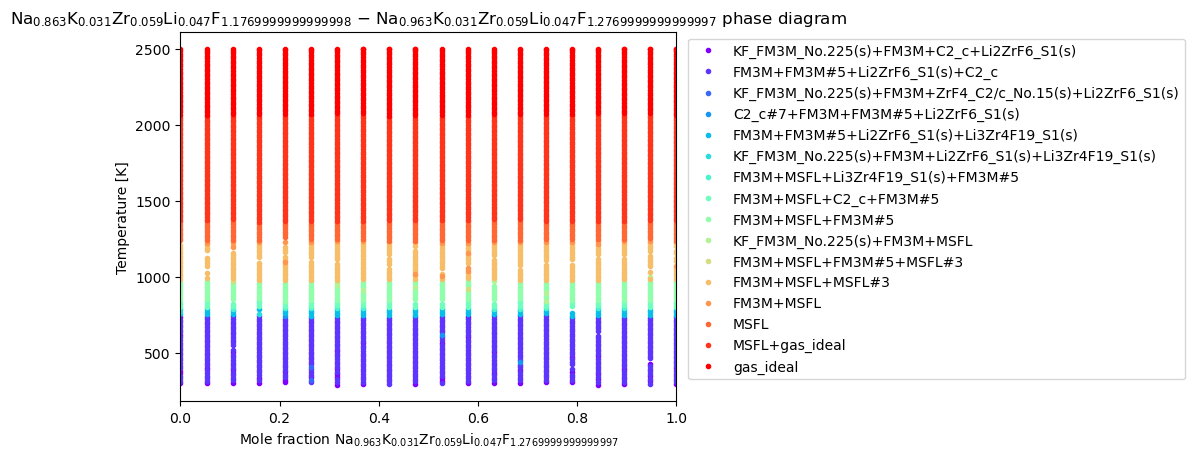

(1241.6025559284117, 1359.0920693512305)


In [14]:
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150, method='phase diagram', \
                                        plot_diagram=True, phase_tolerance=0))

### Results
Interestingly, the first temperature where the pure MSFL phase forms is around 1250 K, much  higher than calculated with the default method, although it's worth noting that the first phase containing MSFL  (FM3M + MSFL + Li3Zr4F19_S1(s) + FM3M#5) appears at around the melting temperature calculated earlier. So the salt _begins_ to melt at this point, but there are still various solid solutions present. If the salt is heated to this temperature, it may be enough to startup the reactor (if a large fraction of the salt is liquid) after which more heat will be supplied and will eventually raise the temperature so that there are only a small amount of solid phases left (i.e. FM3M at 1000 up to 1241, near the boiling point). Also, it's worth noting that the _pure_ gas phase (used to determine the boiling point) agrees well with the default method

Also, the mere presence of a phase in an amount greater than the phase tolerance (if a phase is present in less than this amount it is not considered by thermochimica) say the MSFL phase, does not mean the salt will be _mostly_ liquid. The phase change process is not instantaneous, and as the above plot shows, various amounts of the liquid phase are present (along with their solid solution counterparts) for quite some time before the _only_ stable phase is MSFL. To get a better understanding, it's helpful to look at the phase fractions. 

### The Melting/Boiling Transition

In [11]:
# First do the melting/boiling point calculation (this performs a series of thermochimica calculations)
tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150, phase_tolerance=0)

Thermochimica calculation initiated.


Thermochimica calculation finished.


(805.3691275167786, 1375.8389261744967)

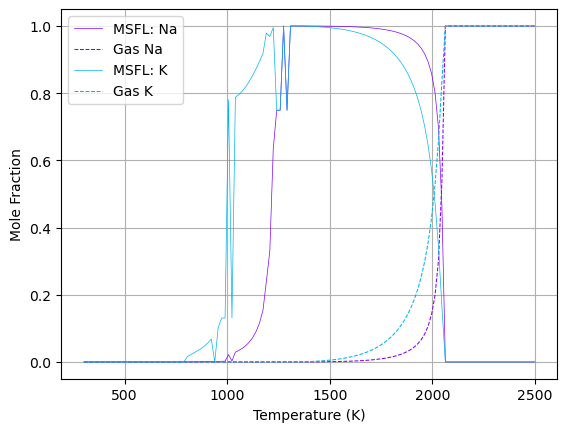

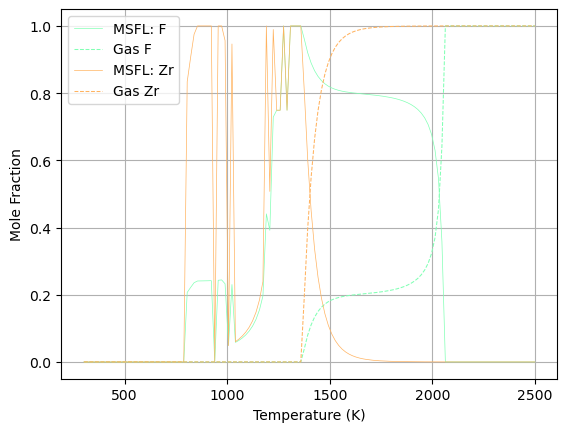

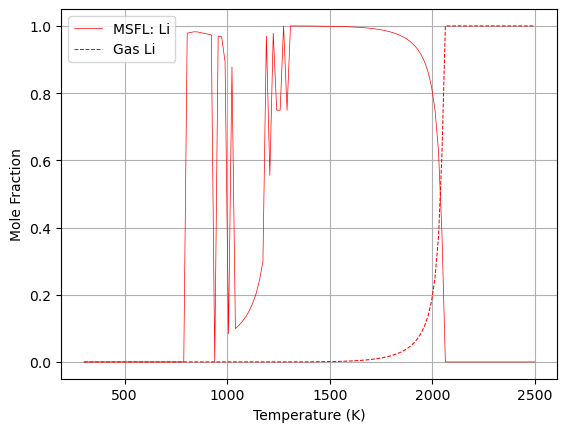

<Figure size 640x480 with 0 Axes>

In [6]:
# Now plot the phase fractions
output = tta.thermoOut(default=True)

num_colors = len(elements_used)
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))
for index, (element, color) in enumerate(zip(elements_used, colors)):
    temperatures, mole_fraction_liquid = output.get_phase_fraction_by_element(element, 'MSFL')
    _, mole_fraction_gas = output.get_phase_fraction_by_element(element, 'gas_ideal')
    plt.plot(temperatures, mole_fraction_liquid, color=color, linewidth=0.5, label=f'MSFL: {element}')
    plt.plot(temperatures, mole_fraction_gas, color=color, linestyle='dashed', linewidth=0.75, label=f'Gas {element}')
    if index % 2 or index == len(elements_used) -1:
        plt.xlabel('Temperature (K)')
        plt.ylabel('Mole Fraction')
        plt.legend()
        plt.grid()
        plt.show()
        plt.clf()

So, while there is some variation between the phases, we see that the actual onset of the liquid and gas phases (when the mole fraction becomes decently large) is at a higher temperature than the simple `calculate_melting_and_boiling` function would indicate. A more useful graph, however, is the phase fraction of the two phases of interest, i.e. MSCL and gas_ideal.

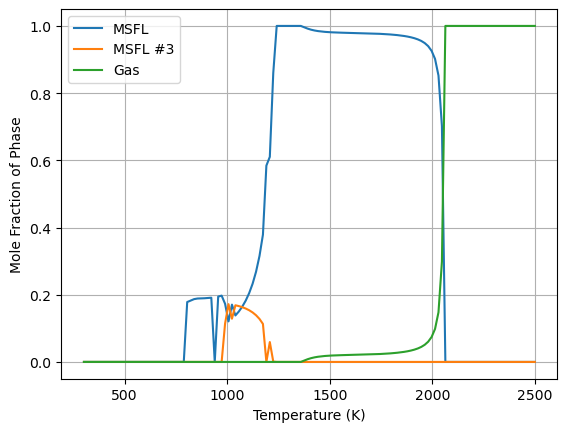

In [7]:
mole_fraction_liquid = output.get_phase_fraction('MSFL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSFL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, mole_fraction_liquid, label='MSFL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSFL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()

So, although the liquid phase begins at 800 K, as calculated, the bulk of the molten salt is not liquid until around 1250 K. Likewise with the gas phase, although a small fraction is present at 1350 K, the bulk of the salt is still liquid, and only really vaporizes at around 2000 K. This behavior should be contrasted with a more simple substance like ice/water, which boils and melts at a single temperature, although it is absorbing energy and more of it is being converted to another phase, this occurs at a _single_ temperature. This discontinuous phase behvaior is somewhat demonstrated at 2000 K, but there is still a small amount of void present from 1350 K on. 

To get a better understanding of the functional boiling and melting temperatures, it's better to consider the point at which _most_ (say more than 90%) of the salt is liquid or solid. Recalculating the melting and boiling points with this tolerance, we get

In [8]:
tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150, phase_tolerance=0.9)

Thermochimica calculation initiated.
Thermochimica calculation finished.


(1241.6107382550335, 2063.758389261745)

Which is more in line with the plot above, and will be more useful for practically evaluating candidate salts. Now we examine the role of LiF in lowering the melting point

### The Effect of Lithium
To demonstrate the effect of Li on the melting point, a full pseudo binary phase diagram will be plotted below

In [9]:
# Set up the calculation parameters

press = 1
tunit = 'K'
punit = 'atm'
munit = 'moles'

xlo = 0.0
xhi = 1.0
nxstep = 120
tlo = 500
thi = 2000
ntstep = 120

elements_used =  ['Na', 'K', 'F', 'Zr', 'Li'] 
left_endmember_composition = {'Na F': 0.906, 'Zr F_4': 0.062, 'K F': 0.032} # No LiF, other components were increased so fraction adds to 1, but same ratios
right_endmember_composition = {'Na F': 0.863, 'Zr F_4': 0.059, 'K F': 0.031, 'Li F': 0.047} # With LiF

In [ ]:
# Run the calculation
calc = tta.pseudo_binary_calculation(xlo, xhi, nxstep, tlo, thi, ntstep, elements_used,\
                                left_endmember_composition, right_endmember_composition)

NOTE: Running the thermochimica calculation isn't that intensive, but parsing the data and creating a pseudo binary phase diagram can be. This notebook might get killed if it requests too much memory. If that is the case, happily reduce the number of temperature and/or composition steps to maintain reasonable memory usage.

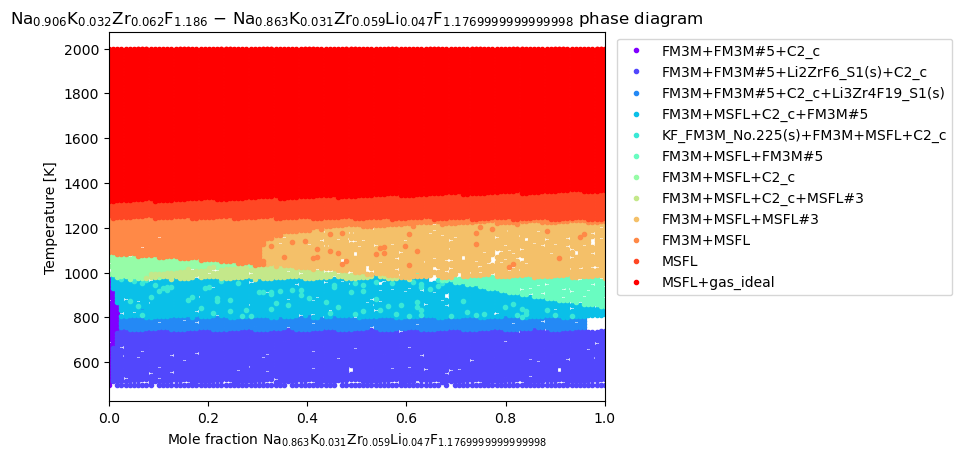

In [12]:
loaded_output = tta.thermoOut(default=True)
diagram = tta.pseudoBinaryDiagram(left_endmember_composition, right_endmember_composition, default=True, \
                                plot_everything=True, ntstep=ntstep, nxstep=nxstep)
diagram.plot_phase_regions(plot_marker='.', plot_mode='region')
diagram.plot.fig.savefig(f"effectOfLithium.png", bbox_inches='tight', dpi=500)
plt.show()

---
Note that the KF_FM3M_No.225(s) + FM3M + MSFL + C2_c phase is the first phase continaining liquid (i.e. MSFL)and when lithium is added, this phase occurs at a much lower temperature, around 800 K instead of around 1000 K.

Interestingly we see that the phase boundaries don't quite agree with those calculated using the `calculate_melting_and_boiling` method. For comparison, the melting and boiling point calcualtion of the salt with and without lithium is shown below

In [16]:
print(f'Without lithium: {tta.calculate_melting_and_boiling(thermochimica_path, output_path, output_name, data_file, left_endmember_composition, elements_used, ntstep=150, phase_tolerance=0)}')
print(f'With lithium: {tta.calculate_melting_and_boiling(thermochimica_path, output_path, output_name, data_file, right_endmember_composition, elements_used, ntstep=150, phase_tolerance=0)}')

Thermochimica calculation initiated.


Thermochimica calculation finished.
Without lithium: (989.9328859060404, 1325.5033557046982)
Thermochimica calculation initiated.
Thermochimica calculation finished.
With lithium: (805.3691275167786, 1375.8389261744967)


## A Revised Optimization
Due to the gradual character of the phase change in certain molten salts (some have sharply defined boundaries between liquid and gas phases, e.g. see [this plot](../boilingAndMeltingPoints/phase_diagram.png) for FLiNaK) it is necessary to consider a phase tolerance when calculating the melting and boiling points. We can update our optimization constraint to include a phase tolerance of 0.9 (the default) to acheive this. Also, we lower the allowable maximum melting point to 850 K (which will make the convergence slower, because the optimization is more constrained, but will result in better coolant salts).

In [4]:
T_max = 750 # Maximum melting point

def check_melting_point(x, endmembers, elements_used):
    x = np.append(x, 1-sum(x))

    # Convert from NaF to Na F (unfortunate mismatch in convention)
    new_endmembers = [convert_to_thermochem_name(endmember) for endmember in endmembers]
    salt = dict({endmember: x[i] for i, endmember in enumerate(new_endmembers)})

    try:
        T_m, _ = tta.calculate_melting_and_boiling(salt, elements_used, suppress_output=True, phase_tolerance=0.9)
        return T_max - T_m
    except:
        # Return a large negative value to indicate that the constriaint was not satisfied
        return -1E+06 # The supplied salt does not have a melting or boiling point in the given range (it could be that the salt sublimates)

In [5]:
endmembers = ['NaF', 'ZrF4', 'KF', 'LiF', 'BeF2']
elements_used = ['Na', 'F', 'K', 'Zr', 'Li', 'Be']

# Define the constraints in a format that `minimize` can use
cons = ({'type': 'ineq', 'fun': constraint}, \
        {'type': 'ineq', 'fun': check_melting_point, 'args': (endmembers, elements_used), 'tol': '0.1'})

guess = [0.115, 0.04, 0.42, 0.41] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 0.05), (0.001, 1), (0.001, 1)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={
        'verbose': 3, 
        'gtol': 1e-4, 
        'xtol': 1e-4, 
        'maxiter': 500,
        'initial_constr_penalty': 100.0,
        'initial_tr_radius': 1.0,
        'initial_barrier_tolerance': 0.1
    },
    args=endmembers
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   5   |   0   | -4.2134e+04 | 1.00e+00 | 1.03e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   0   |
|   2   |  10   |   1   | -4.2134e+04 | 4.08e-01 | 1.03e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   2   |
|   3   |  15   |   3   | -4.2134e+04 | 6.59e-01 | 1.84e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   4   |
|   4   |  20   |   6   | -4.2134e+04 | 6.59e-02 | 1.84e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   4   |
|   5   |  25   |   9   | -4.2134e+04 | 6.59e-02 | 1.57e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   4   |
|   6   |  30   |  13   | -4.2131e+04 | 3.69e-01 | 1.57e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   1   |
|   7   |  35   |  17   | -4.2131e+04 | 5.58e-02 | 1.57e+04 | 0.00e+00 | 1.00e+03 |  1.00e-01   |   1   |
|   8   |  40   |  21   | -4.2127e+04 | 3.13e-

In [6]:
result

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -42548.07317194883
                 x: [ 1.322e-01  3.226e-02  4.109e-01  4.177e-01]
               nit: 92
              nfev: 330
              njev: 66
              nhev: 0
          cg_niter: 222
      cg_stop_cond: 4
              grad: [-6.602e+04 -1.137e+05 -5.854e+04 -8.799e+04]
   lagrangian_grad: [ 1.121e+02 -1.965e-10  1.450e+03 -1.565e+03]
            constr: [array([ 6.968e-03]), array([ 1.177e+02]), array([ 1.322e-01,  3.226e-02,  4.109e-01,  4.177e-01])]
               jac: [array([[-1.000e+00, -1.000e+00, -1.000e+00,
                            -1.000e+00]]), array([[ 0.000e+00,  1.695e+09,  0.000e+00,
                             0.000e+00]]), array([[ 1.000e+00,  0.000e+00,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00,  0.000e+00,
                             0.000e+00],
          

---
And the result is $\text{NaF}$ - $\text{ZrF}_4$ - $\text{KF}$ - $\text{LiF}$ - $\text{BeF}_2$ ($13.2$ - $3.2$ - $41.09$ - $41.77$ - $0.0$ mole %) where ZrF4 is at its maximum mole fraction, and all components (other than LiF) are at their minimum. 

In [7]:
final_coolant_salt_composition = {'Na F': 0.132, 'Zr F_4': 0.032, 'K F': 0.4109, 'Li F': 0.4177}
elements_used =  ['Na', 'K', 'F', 'Zr', 'Li'] 
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150))

Thermochimica calculation initiated.


Thermochimica calculation finished.
(721.4765100671142, 1979.8657718120808)


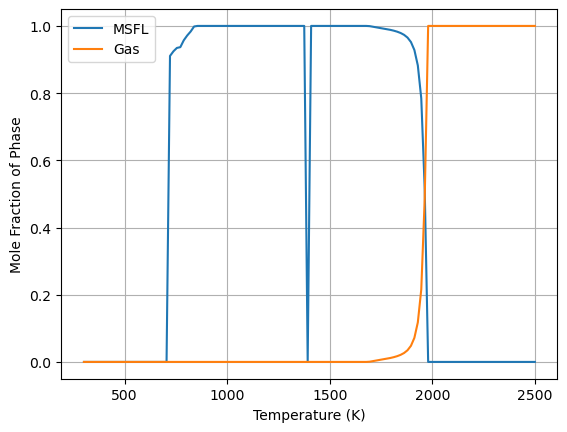

In [8]:
output = tta.thermoOut(default=True)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSFL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSFL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, np.array(mole_fraction_liquid) + np.array(mole_fraction_liquid_3), label='MSFL')
# plt.plot(temperatures, mole_fraction_liquid_3, label='MSFL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()

## Comparison With Moltex's Calculation
They claim to acheive a melting point of 658 K with the following coolant salt: $\text{ZrF}_4$ - $\text{NaF}$ - $\text{KF}$ ($42$ - $10$ - $48$ mole %) and a melting/boiling point of 730/1837 K for the fuel salt: $\text{NaCl}$ - $\text{PuCl}_3$ - $\text{UCl}_3$ ($60$ - $20$ - $20$ mole %), so perhaps it is possible to acheive a lower melting point by allowing for a larger fraction of $\text{ZrF}_4$, in fact, it might even be the case that the neutronically problemmatic $\text{LiF}$ is no longer required.

## Raising the $\text{ZrF}_4$ Minimum
Lastly, we will perform a calculation where we raise the minimum allowed amount of $\text{ZrF}_4$ to 0.5 and don't consider LiF, also, we lower the maximum melting point to 700 K.

In [33]:
T_max = 750 # Maximum melting point

def check_melting_point(x, endmembers, elements_used):
    x = np.append(x, 1-sum(x))

    # Convert from NaF to Na F (unfortunate mismatch in convention)
    new_endmembers = [convert_to_thermochem_name(endmember) for endmember in endmembers]
    salt = dict({endmember: x[i] for i, endmember in enumerate(new_endmembers)})

    try:
        T_m, _ = tta.calculate_melting_and_boiling(salt, elements_used, suppress_output=True, phase_tolerance=0.9)
        return T_max - T_m
    except:
        # Return a large negative value to indicate that the constriaint was not satisfied
        return -1E+06 # The supplied salt does not have a melting or boiling point in the given range (it could be that the salt sublimates)

endmembers = ['NaF', 'ZrF4', 'KF']
elements_used = ['Na', 'F', 'K', 'Zr']

cons = ({'type': 'ineq', 'fun': constraint}, \
        {'type': 'ineq', 'fun': check_melting_point, 'args': (endmembers, elements_used)})

guess = [0.45, 0.05] # An initial guess salt composition
bounds = [(0.001, 1), (0.001, 0.75)]
 
# Now minimize the objective function
result = minimize(
    objective, 
    guess, 
    method='trust-constr',  # Using a different optimization method
    jac='2-point',          # Finite difference approximation if you do not provide a gradient
    constraints=cons,
    bounds=bounds,
    options={
        'verbose': 3, 
        'gtol': 1e-4, 
        'xtol': 1e-4, 
        'maxiter': 500,
        'initial_constr_penalty': 1000000.0,
        'initial_tr_radius': 1.0,
        'initial_barrier_tolerance': 0.1
    },
    args=endmembers
)

In [ ]:
result

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -40063.99031879125
                 x: [ 1.196e-01  5.110e-01]
               nit: 192
              nfev: 531
              njev: 177
              nhev: 0
          cg_niter: 182
      cg_stop_cond: 4
              grad: [-3.635e+04 -3.048e+04]
   lagrangian_grad: [-7.736e+02  7.736e+02]
            constr: [array([ 3.694e-01]), array([-2.348e+02]), array([ 1.196e-01,  5.110e-01])]
               jac: [array([[-1.000e+00, -1.000e+00]]), array([[-6.779e+09, -6.779e+09]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [531, 531, 0]
       constr_njev: [0, 0, 0]
       constr_nhev: [0, 0, 0]
                 v: [array([-2.605e-09]), array([-4.963e-06]), array([ 1.940e+03, -2.391e+03])]
            method: tr_interior_point
        optimality: 773.6033765517454
  constr_violation: 234.84848484848487

So, the optimal salt is $\text{NaF}$ - $\text{ZrF}_4$ - $\text{KF}$ ($15.8$ - $49.2$ - $35.0$ mole %)

In [30]:
final_coolant_salt_composition = {'Na F': 0.45, 'Zr F_4': 0.05, 'K F': 0.5}
elements_used =  ['Na', 'K', 'F', 'Zr'] 
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150))

Thermochimica calculation initiated.


Thermochimica calculation finished.
(989.9328859060404, 1963.0872483221478)


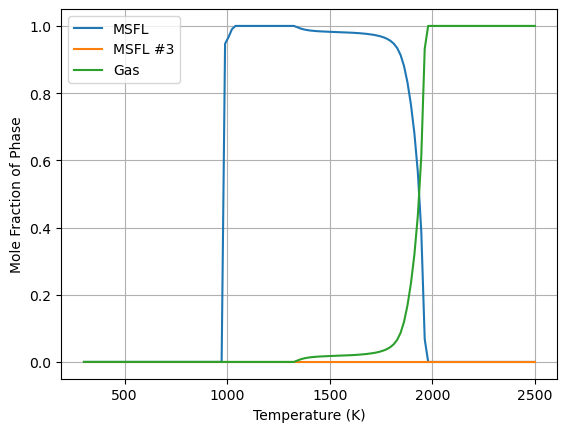

In [31]:
output = tta.thermoOut(default=True)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSFL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSFL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, mole_fraction_liquid, label='MSFL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSFL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()

## Comparison With Other Common Coolant Salts
A common choice for coolant salt is $\text{LiF}$ - $\text{NaF}$ - $\text{KF}$ ($46.5$ - $11.5$ - $42.0$ mole %)

In [23]:
final_coolant_salt_composition = {'Li F':0.465, 'Na F': 0.115, 'K F': 0.42}
elements_used =  ['Na', 'K', 'F', 'Li'] 
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150))

Thermochimica calculation initiated.
Thermochimica calculation finished.
(738.255033557047, 1979.8657718120808)


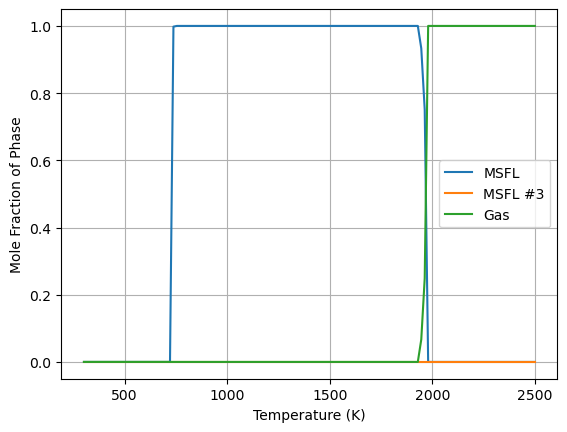

In [24]:
output = tta.thermoOut(default=True)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSFL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSFL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, mole_fraction_liquid, label='MSFL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSFL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()

---
And the Moltex salt: $\text{ZrF}_4$ - $\text{NaF}$ - $\text{KF}$ ($42$ - $10$ - $48$ mole %)

In [35]:
final_coolant_salt_composition = {'Zr F_4':0.42, 'Na F': 0.10, 'K F': 0.48}
elements_used =  ['Na', 'K', 'F', 'Zr'] 
print(tta.calculate_melting_and_boiling(final_coolant_salt_composition, elements_used, ntstep=150))

Thermochimica calculation initiated.
Thermochimica calculation finished.
(1073.8255033557048, 1778.523489932886)


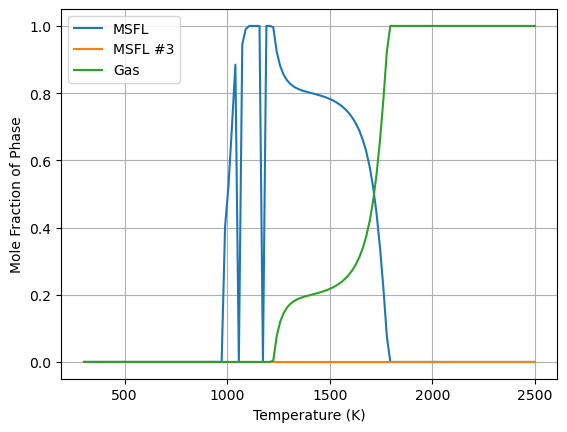

In [36]:
output = tta.thermoOut(default=True)
temperatures = output.temperatures.values()
mole_fraction_liquid = output.get_phase_fraction('MSFL')
mole_fraction_liquid_3 = output.get_phase_fraction('MSFL#3')
mole_fraction_gas = output.get_phase_fraction('gas_ideal')

plt.plot(temperatures, mole_fraction_liquid, label='MSFL')
plt.plot(temperatures, mole_fraction_liquid_3, label='MSFL #3')
plt.plot(temperatures, mole_fraction_gas, label='Gas')
plt.xlabel('Temperature (K)')
plt.ylabel('Mole Fraction of Phase')
plt.grid()
plt.legend()
plt.show()

Which most certainly doesn't have the claimed melting point.

In [9]:
salt = {'NaF': 0.115, 'ZrF4': 0.04, 'KF': 0.42, 'LiF': 0.41, 'BeF2': 0.015}
endmembers = list(salt.keys())
elements_used =  ['Na', 'K', 'F', 'Zr', 'Li', 'Be'] 
check_melting_point(np.array([0.115, 0.04, 0.42, 0.41]), endmembers, elements_used)
print(tta.calculate_melting_and_boiling(salt, elements_used, ntstep=150))

67.1717171717172